
# Example - 1 : Convection-Diffusion Equation
- Partial Differential Equation: A 2-dimensional convection-diffusion equation is given by: 
    
    \begin{align*}
    \frac{\partial T(x, y, t)}{\partial t} &= \mathcal{D} \Bigl(\frac{\partial^2 T(x, y, t)}{\partial x^2} + \frac{\partial^2 T(x, y, t)}{\partial y^2}\Bigr) \\
    &\quad- v_x \frac{\partial T(x, y, t)}{\partial x} - v_y \frac{\partial T(x, y, t)}{\partial y} \\
    &\quad+ \mathcal{S(x, y, t)}, 
    \end{align*}
    where T is the variable of interest (concentration of species or temperature), $\mathcal{D}$ is diffusivity, $v_x$ and $v_y$ are drift velocities in x and y directions, and $S$ is the source term.

- Initial and Boundary Conditions: The spatial domain is 
    $[0, 10] \times [0, 9.5]$ with 20 grid points in each dimension. 
    The right and left boundaries are periodic. The top and bottom boundary conditions are Dirichlet with $T(x, 0) = T(x, 9.5) = 0$. 
    The initial condition is $T(x,y,0) = 0$. 

- Discretization: We choose a uniform grid in space, and the Laplacian operator is discretized with second-order finite differences at each grid point $(i, j)$ as

    \begin{align*}
    \frac{\partial T}{\partial x}\big|_{i,j} &\approx \frac{T_{i+1,j} - T_{i-1,j}}{2h}, \\
    \frac{\partial T}{\partial y}\big|_{i,j} &\approx \frac{T_{i,j+1} - T_{i,j-1}}{2h}, \\
    (\frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2})\big|_{i,j} &\approx \frac{T_{i+1, j} + T_{i-1, j} + T_{i, j+1} + T_{i, j-1} - 4T_{i, j}}{h^2}. 
    \end{align*}

- Input to the system: Heat is injected into the system via the source term which is obtained by interpolating the function

    \begin{equation*}
        \mathcal{S}(x, y, t) = 100 \exp{\Bigl( -0.8\bigl((x-l/2)^2 +(y-l/2)^2)\bigr)\Bigr)}\delta(t-0.2), 
    \end{equation*}
    where $\delta$ is the discrete-time unit impulse. We use a piecewise linear interpolation to obtain the source term as a continuous-time function $\mathcal{S}(x, y, t)$.

- LTI system: Semi-discretized convection-diffusion equation is an LTI system 

    \begin{align*}
        x'(t) &= Ax(t) + Bu(t),\\
        y(t)  &= Cx(t) + Du(t).
    \end{align*}

- Important points in this example:
    - The state matrix in this case is not normal and hence not unitarily diagonalizable. Moreover, the state matrix has a repeated eigenvalue - $0$ with an algebraic multiplicity of 40 and the rest of the eigenvalues have a multiplicity of 1.
    - The computed dynamic neural network consists of one horizontal layer with 40 neurons and the rest with 1 neuron each.
    - We show that the dynamic neural network accurately simulates this system as compared to a numerical solver.



In [1]:
import sys
sys.path.insert(0, "../../")
import numpy as np
import scipy.linalg as LA
from dynamic_neural_networks.utils import *
from dynamic_neural_networks.transformations.helper_functions import *
from dynamic_neural_networks.transformations.sorted_real_schur_forms import *
from dynamic_neural_networks.model.dnn import *
from dynamic_neural_networks.model.state_space_model import *
from dynamic_neural_networks.utils.helper_functions import *
from dynamic_neural_networks.data.convection_diffusion_equation_2d import *

import matplotlib.pyplot as plt
from scipy import signal
from matplotlib.animation import FFMpegWriter, PillowWriter
from sklearn.cluster import AffinityPropagation

from IPython.display import display, Math, Latex

import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
from matplotlib import cm, colors

cmap = cm.jet

expensive_asserts = False

Set parameters 

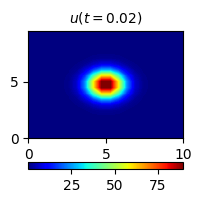

In [2]:
# Problem setup
# Dimensions of the LTI system
d_in = 400  # Input dimension  (<-> Source term: Heat source/sink at grid points)
d_state = 400  # State dimension  (<-> Temperature)
d_out = 400  # Output dimension (<-> Temperature (state = output))
ssm_dim = [d_state, d_in, d_out]  # Dimensions of the state-space model

# Spacial discretization
nx = 20  # Number of grid points in the first dimension
ny = 20  # Number of grid points in the second dimension
l_x = 10.0
l_y = (ny - 1) / nx * l_x
dx = l_x / (nx)  # Spacing between consecutive grid points on the uniform grid
x = np.linspace(0, l_x, nx, endpoint=False)
y = np.linspace(0, l_y, ny)
x_grid, y_grid = np.meshgrid(x, y)

# Constants
v_x = -0.6
v_y = 0
drift_vel = [v_x, v_y]
diffusivity = 1.4

# Get state-space matrices for this example
A, B, C, D = get_ssm(ssm_dim, nx, ny, dx, diffusivity, drift_vel)
ssm = state_space_model(A, B, C, D)

# Timesteps
t_0 = 0.0  # Initial time
t_end = 10.0  # Final time
dt = 1e-1  # Time-step size
timesteps = np.arange(t_0, t_end + dt, dt)

# Method to interpolate the input function within each time-step
u_interp = "piecewise_linear"  # 'piecewise_constant', 'piecewise_linear', 'sample'

# Set u(t): Forcing term (Heat source/sink) over the grid as a function of time
inputs = get_input(l_x, l_y, nx, ny, timesteps, d_in, show_input=True)

# Ignore the following lines unless u_interp == 'sample'
if u_interp == "sample":
    t = timesteps
    i = np.arange(0, d_in, 1)
    u = inputs[0]
    u = u(np.reshape(t, (len(t), 1)), np.reshape(i, (1, len(i))))

Simulate the LTI system using the dynamic neural network

In [3]:
#############################################
# Dynamic Neural Network Parameters
#############################################
# Dynamic Neural Network Parameters
n_clusters = 199  # Number of clusters of close eigenvalues
outer_loop = "neurons"  # 'neurons', 'timesteps'
ode_solver_rel_tol = 1e-10  # relative tolerance for ODE solver
ode_solver_abs_tol = 1e-10  # absolute tolerance for ODE solver
clustering_alg = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto", tol=1e-6)
params = forward_pass_parameters(
    outer_loop=outer_loop,
    ssm_input_interpolation=u_interp,
    solver_routine="solve_ivp",
    ode_solver_params=ode_solver_parameters(
        atol=ode_solver_abs_tol, rtol=ode_solver_rel_tol, ode_solver="DOP853"
    ),
)  # Parameters concerning forward pass of a DyNN

c:\Users\chinm\miniconda3\envs\dynn\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\chinm\miniconda3\envs\dynn\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\chinm\miniconda3\envs\dynn\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\chinm\miniconda3\envs\dynn\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\chinm\miniconda3\envs\dynn\Lib\subprocess.py", line 1538, in 

Condition number of the transformation matrix =  7.429431820954443


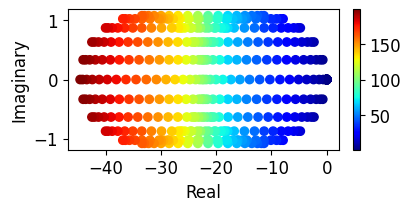

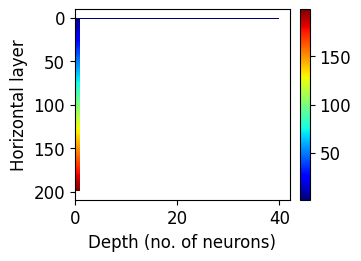

In [4]:
# Initialize the dynamic neural network
dynn = dynamic_neural_network(ssm=ssm)

# Simulate the LTI system using a dynamic neural network
dynn.fit(clustering_alg, verbose=0, show_plots=False)

# Condition number of the transformation matrix
print("Condition number of the transformation matrix = ", dynn.cond_num)

# Plot eigenvalue clusters and DyNN architecture
dynn.plot_architecture(figname="conv_diff", fig_size_1=(4, 2), fig_size_2=(3.5, 2.5), fontsize = 12)

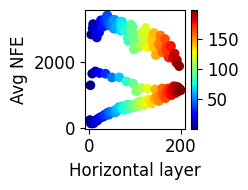

In [5]:
# Perform forward pass and compute output
y_dynn = dynn.predict(inputs, timesteps, params)

# Plot: Avg number of function evaluations in each horizontal layer.
dynn.plot_NFE(figname="conv_diff", fig_size=(2.5, 2), y_label="Avg NFE", fontsize=12)

In [6]:
# Simulate the LTI system using python routine lsim
y_lsim = numerical_simulation_lsim(timesteps, inputs[0], ssm, interp=True)

# Simulate the LTI system using python routine solve_ivp
y_solve_ivp, nfe_solver = numerical_simulation_ivp_solve(
    ssm,
    inputs,
    timesteps,
    u_interp,
    outer_loop,
    rtol=ode_solver_rel_tol,
    atol=ode_solver_abs_tol,
)

Compare the simulation results

In [7]:
# Compute relative and absolute errors
abs_err_lsim = abs(y_dynn - y_lsim)
print("Max absolute error (DyNN and solver:lsim) :", np.amax(abs_err_lsim))

abs_err_solve_ivp = abs(y_dynn - y_solve_ivp)
print("Max absolute error (DyNN and solver:solve_ivp) :", np.amax(abs_err_solve_ivp))

abs_err_between_solvers = abs(y_lsim - y_solve_ivp)
print("Max absolute error between solvers :", np.amax(abs_err_between_solvers))

Max absolute error (DyNN and solver:lsim) : 5.776651068600813e-08
Max absolute error (DyNN and solver:solve_ivp) : 6.103633426457478e-07
Max absolute error between solvers : 6.070110385447691e-07


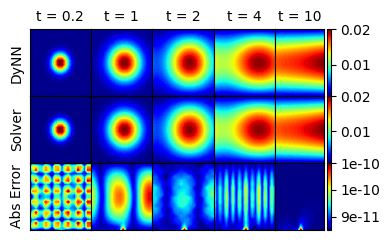

In [8]:
# Comparison of PDE solutions: (a) using the constructed dynamic neural
# network (DyNN), and (b) numerical solver along with the absolute errors.
compare_pde_solutions(
    timesteps, l_x, l_y, nx, ny, y_dynn, y_lsim, fig_size=(4, 2.5), 
    save_fig=True, figname='conv_diff_sol_err.pdf', fontsize = 12)#, ticks_sol = [0, 0.2], ticks_err = [1e-10, 5e-11], , ticks_err = [1e-10, 2e-10]

In [9]:
# Uncomment the following for creating a video of the simulation
"""
    create_simulation_video_contour(timesteps, l_x, l_y, nx, ny, y_dynn, y_lsim, 
                        abs_err_lsim, fig_size=(7., 4.))
"""

'\n    create_simulation_video_contour(timesteps, l_x, l_y, nx, ny, y_dynn, y_lsim, \n                        abs_err_lsim, fig_size=(7., 4.))\n'